In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

In [65]:
x_train, y_train, x_valid, y_valid = get_data()

x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       partial(BatchTransformXCallback, mnist_view), 
        CudaCallback]

In [5]:
nfs = [8,16,32,64,64]

In [6]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train: [1.12836625, tensor(0.6236, device='cuda:0')]
valid: [0.1916191162109375, tensor(0.9422, device='cuda:0')]
train: [0.160195263671875, tensor(0.9510, device='cuda:0')]
valid: [0.10667281494140625, tensor(0.9681, device='cuda:0')]
CPU times: user 4.49 s, sys: 1.16 s, total: 5.64 s
Wall time: 5.22 s


## Batchnorm

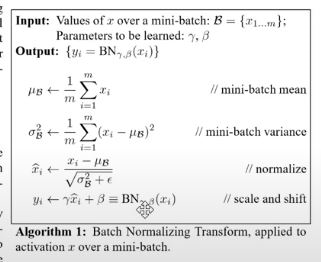

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

In [87]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        #NB: pytorch bn mom is opposite of what you'd expect so mom=0.1 really means real-mom = 0.9
        self.mom, self.eps = mom, eps
        # parameters to be learned
        #can also initialize them as tensor(1.) and tensor(0.) as you're doing element-wise multiplication. Remember to ask about this!
        self.mults = nn.Parameter(torch.ones(nf,1,1)) # gamma
        self.adds = nn.Parameter(torch.zeros(nf,1,1)) # beta. This is just bias
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        
        
    def update_stats(self, x):
        # keepdim=True keeps the unit axes in the positions 0,2,3 so it will still broadcast nicely
        m = x.mean((0,2,3), keepdim=True) # average over batch, height and width. so result is mean for each channel
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v

    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means, self.vars
        x = (x-m)/ (v+self.eps).sqrt()
        #print(self.mults) all values are different HAWW!
        return x*self.mults + self.adds

We normalize during training but during inference if we get a totally different image, we might remove all the interesting things about it. So what we do is keep track of exponential weighted moving average of the means and the variances. Exponential weighted moving average is also known as lerp or linear interpolation. So during infrence we normalize the inputs based on the self.means and self.vars above.  
  
*What does register_buffer do? *   
Its almost the same as self.vars= torch.ones() but it also:  
- if we move the model to the gpu, anything that is defined as a register_buffer gets added to the gpu.
- The variances and the means are part of the model. SO if we save the model we gotta save their values. So register_buffer does that for us too.  
  
  
*WHY did we use self.eps=1e-5?*
- Epsilon is a no that you use in comp. science to avoid floating point rounding problems. So it is very common to see it in denominators to avoid dividing by such small no that cause the result to go upto infinity. But Jeremy's view is that we should use epsilon as a hyperparameter that we should be using to train things better. THink var=0 and eps= 0.01 . The overall activations will never be greater than 10x that way(worst case). So it won't blow out.  
  
*NOTE:*  
You initialized the biases(self.adds) to be a torch.ones instead of torch.zeros and your model couldn't go beyond 30% accuracy. Interesting!

In [88]:
# new conv layer which includes BN
def conv_layer(ni, nf, ks=3, stride=2, bn = True, **kwargs):
    # No bias needed if using BatchNorm(bn)
    layers = [nn.Conv2d(ni, nf, ks, padding = ks//2, stride = stride, bias = not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)    

In [89]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a = 0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l,f)
    
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [90]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.2481616015625, tensor(0.9239, device='cuda:0')]
valid: [0.1632505859375, tensor(0.9497, device='cuda:0')]


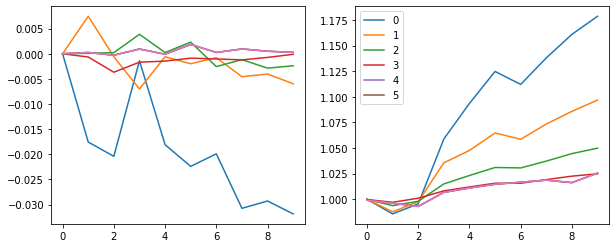

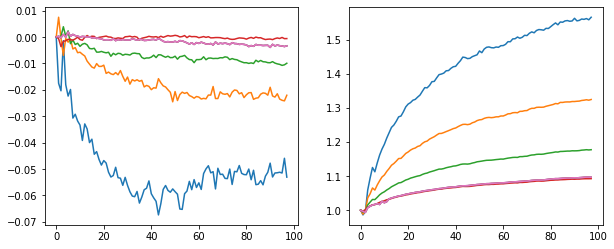

In [91]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

So our training has completely gotten rid of all of the exponential growth followed by the sudden crash that we had before in the 06_cuda_cnn_init nb. 

In [79]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [80]:
%time run.fit(3, learn)

train: [0.28873125, tensor(0.9084, device='cuda:0')]
valid: [0.1532135498046875, tensor(0.9526, device='cuda:0')]
train: [0.084236630859375, tensor(0.9744, device='cuda:0')]
valid: [0.12045992431640624, tensor(0.9603, device='cuda:0')]
train: [0.0606759130859375, tensor(0.9811, device='cuda:0')]
valid: [0.12109517822265625, tensor(0.9645, device='cuda:0')]
CPU times: user 3.95 s, sys: 208 ms, total: 4.16 s
Wall time: 3.59 s


So now we're able to get a 96% accuracy in 3 epochs with a very high LR(=1)

### Builtin batchnorm

In [15]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding = ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps= 1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [16]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [17]:
%time run.fit(3, learn)

train: [0.22081796875, tensor(0.9311, device='cuda:0')]
valid: [0.0788453857421875, tensor(0.9748, device='cuda:0')]
train: [0.06592751953125, tensor(0.9794, device='cuda:0')]
valid: [0.06731171264648438, tensor(0.9792, device='cuda:0')]
train: [0.043606181640625, tensor(0.9862, device='cuda:0')]
valid: [0.06256624145507812, tensor(0.9810, device='cuda:0')]
CPU times: user 3.58 s, sys: 224 ms, total: 3.8 s
Wall time: 3.24 s


### With scheduler

Now let's add the usual warm-up/annealing and try to get to a learning rate of 2.

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [19]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [20]:
run.fit(8, learn)

train: [0.24676041015625, tensor(0.9259, device='cuda:0')]
valid: [0.1261651611328125, tensor(0.9591, device='cuda:0')]
train: [0.079959921875, tensor(0.9749, device='cuda:0')]
valid: [0.146272705078125, tensor(0.9554, device='cuda:0')]
train: [0.24841388671875, tensor(0.9358, device='cuda:0')]
valid: [0.1114506103515625, tensor(0.9672, device='cuda:0')]
train: [0.077782861328125, tensor(0.9760, device='cuda:0')]
valid: [0.07286206665039062, tensor(0.9771, device='cuda:0')]
train: [0.048523408203125, tensor(0.9849, device='cuda:0')]
valid: [0.05661611938476562, tensor(0.9831, device='cuda:0')]
train: [0.0336424951171875, tensor(0.9902, device='cuda:0')]
valid: [0.05242738037109375, tensor(0.9846, device='cuda:0')]
train: [0.02639519775390625, tensor(0.9926, device='cuda:0')]
valid: [0.04868853759765625, tensor(0.9854, device='cuda:0')]
train: [0.02077145751953125, tensor(0.9945, device='cuda:0')]
valid: [0.0478761474609375, tensor(0.9859, device='cuda:0')]


So we can totally train even with a LR of 2.0. Yayy!  
Turns out it even works when max_lr=6.0  
[Crashes when max_lr=10.0]

In [46]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 6.), sched_lin(6., 0.1)]) 

In [47]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [48]:
run.fit(8, learn)

train: [0.30519955078125, tensor(0.9075, device='cuda:0')]
valid: [1.37632998046875, tensor(0.8003, device='cuda:0')]
train: [0.09850685546875, tensor(0.9702, device='cuda:0')]
valid: [0.06689632568359374, tensor(0.9805, device='cuda:0')]
train: [0.060383271484375, tensor(0.9809, device='cuda:0')]
valid: [0.0587935302734375, tensor(0.9826, device='cuda:0')]
train: [0.03309061767578125, tensor(0.9897, device='cuda:0')]
valid: [0.050022344970703125, tensor(0.9856, device='cuda:0')]
train: [0.019975380859375, tensor(0.9939, device='cuda:0')]
valid: [0.049350192260742186, tensor(0.9859, device='cuda:0')]
train: [0.011690994873046876, tensor(0.9966, device='cuda:0')]
valid: [0.04181661376953125, tensor(0.9892, device='cuda:0')]
train: [0.006603004150390625, tensor(0.9984, device='cuda:0')]
valid: [0.038568280029296874, tensor(0.9889, device='cuda:0')]
train: [0.004098196411132813, tensor(0.9993, device='cuda:0')]
valid: [0.03936795959472656, tensor(0.9894, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".  
   
Eg: In image segmentation where you had a bs=4.
When bs=1 then variance=0 so your outputs will be infinite causing the model to break. Hence you can't train with a bs=1. And if its really low then there's a chance that at some point you'll have two really similar values in a batch causing the variance to be very very close to zero, again causing the same problem.  
Also, you can't apply batchnorm on RNNs.

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size    
  
The difference between them in code is that layer-norm means over 1,2,3 dimensions(batch_size) and batch_norm 0,2,3(no of channels)  
  
The reason we don't need a running avg anymore is because we're not taking the mean across all items in the batch; every image has its own mean so there's no concept of having to avg things across a batch

In [24]:
class LayerNorm(nn.Module):
    _constants = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.0))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        #print(m.shape) 512*1*1*1
        v = x.var((1,2,3), keepdim=True)
        x = (x-m)/ ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [25]:
# bias is always True here unlike Batchnorm
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)    

In [26]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [27]:
%time run.fit(3, learn)

train: [nan, tensor(0.1597, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.35 s, sys: 212 ms, total: 4.56 s
Wall time: 3.99 s


The problem is that when we do that and train with a lr(=0.8), it doesn't work. Because we don't have a different normalization for each channel we're just throwing them all together and pretending that they're the same. It helps but it is not as good as BN. You can use it for RNNs tho. It does work on a smaller LR(=0.7).

In [49]:
learn,run = get_learn_run(nfs, data, 0.5, conv_ln, cbs=cbfs)

In [50]:
%time run.fit(3, learn)

train: [0.449706328125, tensor(0.8585, device='cuda:0')]
valid: [0.11973626708984375, tensor(0.9639, device='cuda:0')]
train: [0.0989875390625, tensor(0.9689, device='cuda:0')]
valid: [0.0833111572265625, tensor(0.9743, device='cuda:0')]
train: [0.0645332958984375, tensor(0.9799, device='cuda:0')]
valid: [0.1065222412109375, tensor(0.9665, device='cuda:0')]
CPU times: user 4.26 s, sys: 276 ms, total: 4.54 s
Wall time: 3.96 s


With BN we were able to go upto a max_lr=6.0 with scheduler

*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?  
ANS: Foggy days would have less activations on average. And they'll have less contrast(in other words, they'll have lower variance). So layernorm would cause the means and variances to be normalized the same. So now the sunny day picture and foggy day picture  would have the same overall activations and the amount of contrast. So the Answer's No. YOu literally won't be able to tell the difference between pictures of sunny and foggy. Even if you don't put LayerNorm on the input data(before the first conv), but everywhere in the middle layers will be the same. Anywhere where the overall activation or amount of difference of activation is part of something that you care about, it'll throw it away. Furthermore if your inference time is using a different distribution where that diff distribution is important, it'll throws that away. SO layer Norm's a partial hacky workaround for some genuine problems.

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}  
tijk-batch, channel, ht, width

In [30]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [31]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [32]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [33]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.23 s, sys: 292 ms, total: 4.52 s
Wall time: 3.94 s


*Question*: why can't this classify anything?  
Because we're now taking the mean and variance for every channel and for every image which means we've literally thrown away all the things that helps us classify. InstanceNorm is not stupid because it was never designed for classification but for style-transfer where the authors guessed that these difference in contrast and overall amount were not important for that case.

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

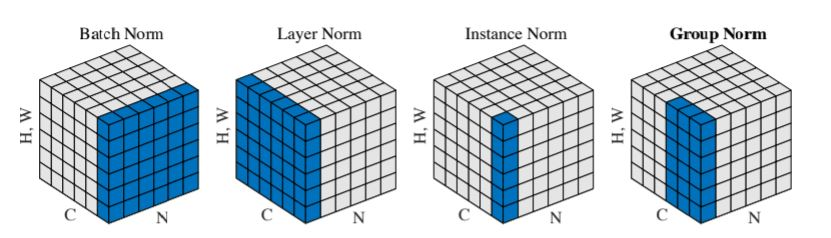

C- Channel
N- Batch
H,W - Height, Width  
Batchnorm is different for each batch.  
LayerNorm is different for each element of the batch.  
InstanceNorm is different for each channel and each batch.   
GroupNorm is the same as InstanceNorm but they arbitarily group a few channels together and do that.

### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

In [51]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [35]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [36]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [37]:
%time run.fit(1, learn)

train: [2.311065625, tensor(0.1941, device='cuda:0')]
valid: [30.27713125, tensor(0.2043, device='cuda:0')]
CPU times: user 1min 20s, sys: 1.38 s, total: 1min 22s
Wall time: 1min 23s


Notice that smaller batch sie takes a lot of time AND The results are awful(20%) {variance is very small}

SOLUTION BELOW(Unpublished research)

### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [56]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1)) 
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
       self.register_buffer('dbias', tensor(0.)) # we wanna make sure that at every point no observation is weighted too highly.
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()# detach stops keeping track of gradients
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc) # counts of the bs= total no of elements in mini-batch/ no of channels or h*w*batch_size
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1) 
        self.dbias = self.dbias* (1-self.mom1)+ self.mom1
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c = c / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch<20): vars.clamp_min_(0.01)# if batch no <20 clamp the variance to 0.01 to avoid blowing out
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

Idea is to use the moving avg statistics not only during inference but also during training time. So if we're using a bs=2 and even if you get a batch where its current variance is close to zero, the moving average would consitute for 90% of that value and so that problem is solved. Unless you're really unlucky and get the variance of the first batch as close to zero.  
You can't take the running avg of variance tho. Particularly because bs may be different. We use the formula  
$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$  
to calculate variance so we keep track of the squuares and the sums and register them as buffers and just go x.sum and (x*x).sum Then we'll take the exponentially moving avg of the sums and the sqrs. ANd then for variance we'll do sqrs/count - (mean)^2.  
Since the bs can vary we also register buffer a count variable and take lerp of the counts variable and keep track of it. So that basially tells us what do we need to divide by each time

In [57]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [58]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [59]:
%time run.fit(1, learn)

train: [0.440892734375, tensor(0.8808, device='cuda:0')]
valid: [0.2688981689453125, tensor(0.9458, device='cuda:0')]
CPU times: user 3min 15s, sys: 1.96 s, total: 3min 17s
Wall time: 3min 20s


This solves the small batch size issue! SHIIIIT!

## What can we do in a single epoch?

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)
learn, run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs = cbfs+
                          [partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [ ]:
%time run.fit(1, learn)

## Simplified BatchNorm

It turns out that we don't actually need to dbias- because for instance, dividing a debiased sum by a debiased count cancels out the dbiases. So we can remove all the debiasing stuff and end up with a simpler class. Also, we hsould save eps as a buffer since it impacts the calculation. Also, we can slightly change the final calculation in forward with one that uses factor and offset to reduce the amount of broadcasting required.

In [2]:
class SimplifiedRunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0
    
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = s.new_tensor(x.numel()/nc) # numel() returns total no of elements in a matrix
        mom1 = s.new_tensor(1 - (1-self.mom)/math.sqrt(bs-1))
        self.sums.lerp_(s, mom1)
        self.sqrs.lerp_(ss, mom1)
        self.count.lerp_(c, mom1)
        self.batch +=bs
        means = self.sums/self.count
        varns = self.sqrs/self.count.sub_(means*means)
        if bool(self.batch<20): varns.clamp_min_(0.01)
        self.factor = self.mults / (vars+self.eps).sqrt()
        self.offset = self.adds - means*self.factor
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        return x*self.factor + selff.offset

NameError: name 'nn' is not defined

In [ ]:
learn, run = get_learn_run(nfs, data, 0.8, conv_rbn, cbs=cbfs+
                          [partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [ ]:
%time run.fit(1, learn)

## Export

In [12]:
nb_auto_export()

<IPython.core.display.Javascript object>